In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ML/hw3-2023')

In [ ]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import svm
from scipy import io
from scipy.stats import multivariate_normal

In [ ]:
def process_raw_datas(datas):
  """
  Given data, return normalized and flattened data
  """
  new_datas = []
  for img in datas:
    img /= np.linalg.norm(img)
    new_datas.append(img)
  new_datas = np.array(new_datas)
  return new_datas.reshape(new_datas.shape[0], -1)

In [ ]:
# load data
data_name = "mnist"
data = np.load(f"./data/{data_name}-data-hw3.npz")
print("\nloaded %s data!" % data_name)
fields = "test_data", "training_data", "training_labels"
for field in fields:
    print(field, data[field].shape)


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)


In [ ]:
# contrast normalize
training_data = process_raw_datas(data["training_data"])
test_data = process_raw_datas(data["test_data"])

In [ ]:
# separate data according to label
data_dict = {}
data_flat = training_data
labels = data["training_labels"].reshape(len(data["training_labels"]), -1)
dataset = np.concatenate([labels, data_flat], axis=-1)
print(dataset.shape)

(60000, 785)


In [ ]:
# q8.1 calculate mean & covariance matrix
mu_arr = []
cov_arr = []
for label in range(10):
  data_tmp = dataset[np.where(dataset[:, 0].astype(np.int64) == label)][:, 1:]
  # print(data_tmp.shape)
  mu = np.mean(data_tmp, axis=0)
  # print(mu.shape)
  mu_arr.append(mu)
  cov = (data_tmp - mu).T @ (data_tmp - mu) / data_tmp.shape[0]
  # print(cov.shape)
  cov_arr.append(cov)

Visualizing covariance matrix for class 4


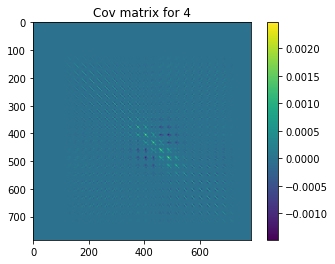

In [ ]:
# q8.2 visualize cov matrix
label = 4
print("Visualizing covariance matrix for class "+str(label))
plt.title("Cov matrix for "+str(label))
plt.imshow(cov_arr[label])
plt.colorbar()
plt.show()


## 8.3a LDA

In [ ]:
# split data
np.random.seed(113)
np.random.shuffle(dataset)
val_set = dataset[0:10000]
train_set = dataset[10000:]
train_pts_nums = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]

In [ ]:
# define GDA(LDA/QDA) model
class GDA:
  def __init__(self, mode="lda"):
    self.mode = mode
    self.mus = []
    self.covs = []
    self.prior_probs = []
    self.cov_invs, self.cov_logdets = [], []

  def train(self, train_set):
    """
    Calculate means and covariance matrixes given x and y
    (If mode set to lda, calculate cov's average.)
    :param train_set: for a training pts, first dim is its label 
    """
    total = train_set.shape[0]
    for label in range(10):
      print("Computing mean and covariance matrix for class {}".format(label))
      data_tmp = train_set[np.where(train_set[:, 0].astype(np.int64) == label)][:, 1:]
      mu = np.mean(data_tmp, axis=0)
      self.mus.append(mu)
      cov = (data_tmp - mu).T @ (data_tmp - mu) / data_tmp.shape[0]
      self.covs.append(cov)
      prior_prob = data_tmp.shape[0]/total
      self.prior_probs.append(prior_prob)
    if self.mode=="lda":
      self.cov = np.average(self.covs, axis=0)
    else:
      self.covs = np.array(self.covs)
    self.get_invs_dets()
      

  def get_invs_dets(self):
    if self.mode=="lda":
      tmp = abs(self.cov)
      tmp = tmp[np.nonzero(tmp)]
      minval = np.min(tmp)
      dim = self.cov.shape[0]
      new_cov = self.cov + np.eye(dim) * minval * 0.001
      self.cov_inv = np.linalg.inv(new_cov)
      sign, cov_logdet = np.linalg.slogdet(new_cov)
      assert(sign!=0)
      self.cov_logdet = sign * cov_logdet
    else:
      tmp = abs(self.covs)
      tmp = tmp[np.nonzero(tmp)]
      minval = np.min(tmp)
      dim = self.covs.shape[1]
      for cov in self.covs:
        new_cov = cov + np.eye(dim) * minval * 0.001
        cov_inv = np.linalg.inv(new_cov)
        sign, cov_logdet = np.linalg.slogdet(new_cov)
        assert(sign!=0)
        self.cov_invs.append(cov_inv)
        self.cov_logdets.append(sign * cov_logdet)


  def calc_probs(self, x):
    """
    For a given input x, return its probabilities of belonging to each class
    """
    probs = np.zeros(10,)
    for i in range(10):
      if self.mode == "lda":
        # extremely slow when using logpdf directly
        # probs[i] = multivariate_normal.logpdf(x, self.mus[i], self.cov, True)
        bias = (x-self.mus[i]).reshape((-1, 1))
        probs[i] = - bias.T @ self.cov_inv @ bias/2 - self.cov_logdet/2 + np.log(self.prior_probs[i])
      else:
        bias = (x-self.mus[i]).reshape((-1, 1))
        probs[i] = - bias.T @ self.cov_invs[i] @ bias/2 - self.cov_logdets[i]/2 + np.log(self.prior_probs[i])
        # probs[i] = multivariate_normal.logpdf(x, self.mus[i], self.covs[i], True) + np.log(self.prior_probs[i])
    return probs

  def predict(self, datas):
    predict_labels = []
    for i, data in enumerate(datas):
      i = (i+1)/datas.shape[0]
      print('\rPredicting：{}{:.2f}%'.format('▉'*int(i*50),(i*100)), end='')
      probs = self.calc_probs(data)
      label = np.argmax(probs)
      predict_labels.append(label)
    return np.array(predict_labels)

  def eval(self, val_set):
    print("Evaluating model...")
    labels = val_set[:, 0]
    datas = val_set[:, 1:]
    predict_labels = self.predict(datas)
    acc = sklearn.metrics.accuracy_score(labels, predict_labels)
    err_digitwise = []
    for i in range(10):
      total = np.sum(labels==i)
      cnt = np.sum(predict_labels[np.where(labels==i)]!=i)
      err_digitwise.append(cnt/total)
    return acc, err_digitwise

In [ ]:
lda_errs = []
lda_errs_digitwise = []
for train_pts_num in train_pts_nums:
  print(f"Using {train_pts_num} data points for training LDA")
  model = GDA("lda")
  model.train(train_set[0:train_pts_num])
  # calculate overall error rate
  total_acc, err_digitwise = model.eval(val_set)
  error_rate = 1-total_acc
  lda_errs.append(error_rate)
  lda_errs_digitwise.append(err_digitwise)
  print(f"\nError rate: {error_rate}")

Using 100 data points for training LDA
Computing mean and covariance matrix for class 0
Computing mean and covariance matrix for class 1
Computing mean and covariance matrix for class 2
Computing mean and covariance matrix for class 3
Computing mean and covariance matrix for class 4
Computing mean and covariance matrix for class 5
Computing mean and covariance matrix for class 6
Computing mean and covariance matrix for class 7
Computing mean and covariance matrix for class 8
Computing mean and covariance matrix for class 9
Evaluating model...
Predicting：▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉100.00%
Error rate: 0.3065
Using 200 data points for training LDA
Computing mean and covariance matrix for class 0
Computing mean and covariance matrix for class 1
Computing mean and covariance matrix for class 2
Computing mean and covariance matrix for class 3
Computing mean and covariance matrix for class 4
Computing mean and covariance matrix for class 5
Computing mean and covariance 

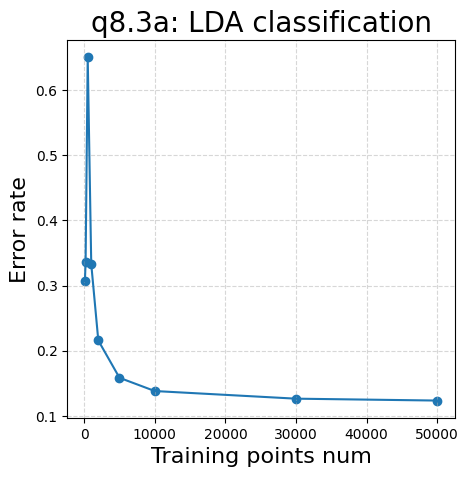

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(train_pts_nums, lda_errs)
plt.scatter(train_pts_nums, lda_errs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Training points num", fontdict={'size': 16})
plt.ylabel("Error rate", fontdict={'size': 16})
plt.title("q8.3a: LDA classification", fontdict={'size': 20})
plt.show()

## 8.3b QDA

In [ ]:
train_pts_nums = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
qda_errs = []
qda_errs_digitwise = []
for train_pts_num in train_pts_nums:
  print(f"Using {train_pts_num} data points for training QDA")
  model = GDA("qda")
  model.train(train_set[0:train_pts_num])
  # calculate overall error rate
  total_acc, err_digitwise = model.eval(val_set[0:1000])
  error_rate = 1-total_acc
  qda_errs.append(error_rate)
  qda_errs_digitwise.append(err_digitwise)
  print(f"\nError rate: {error_rate}")

Using 100 data points for training QDA
Computing mean and covariance matrix for class 0
Computing mean and covariance matrix for class 1
Computing mean and covariance matrix for class 2
Computing mean and covariance matrix for class 3
Computing mean and covariance matrix for class 4
Computing mean and covariance matrix for class 5
Computing mean and covariance matrix for class 6
Computing mean and covariance matrix for class 7
Computing mean and covariance matrix for class 8
Computing mean and covariance matrix for class 9
Evaluating model...
Predicting：▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉100.00%
Error rate: 0.21099999999999997
Using 200 data points for training QDA
Computing mean and covariance matrix for class 0
Computing mean and covariance matrix for class 1
Computing mean and covariance matrix for class 2
Computing mean and covariance matrix for class 3
Computing mean and covariance matrix for class 4
Computing mean and covariance matrix for class 5
Computing mean an

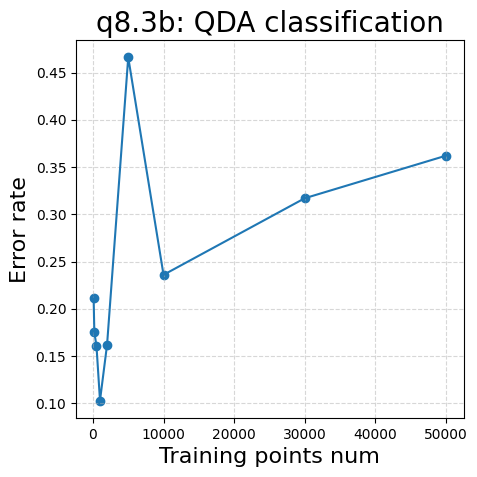

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(train_pts_nums, qda_errs)
plt.scatter(train_pts_nums, qda_errs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Training points num", fontdict={'size': 16})
plt.ylabel("Error rate", fontdict={'size': 16})
plt.title("q8.3b: QDA classification", fontdict={'size': 20})
plt.show()

## 8.3c Digitwise analysis

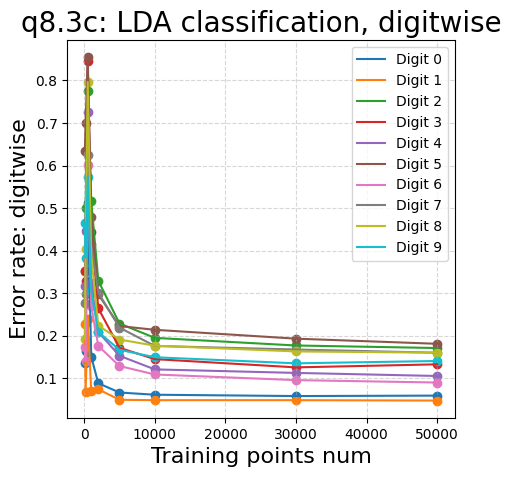

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
legend_list = []
for i in range(10):
  plt.plot(train_pts_nums, np.array(lda_errs_digitwise).T[i])
  plt.scatter(train_pts_nums, np.array(lda_errs_digitwise).T[i])
  plt.grid(True, linestyle='--', alpha=0.5)
  legend_list.append(f"Digit {i}")
plt.xlabel("Training points num", fontdict={'size': 16})
plt.ylabel("Error rate: digitwise", fontdict={'size': 16})
plt.title("q8.3c: LDA classification, digitwise", fontdict={'size': 20})
plt.legend(legend_list)
plt.show()

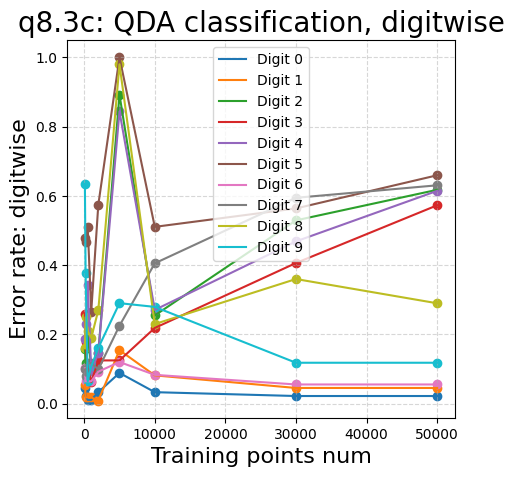

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
legend_list = []
for i in range(10):
  plt.plot(train_pts_nums, np.array(qda_errs_digitwise).T[i])
  plt.scatter(train_pts_nums, np.array(qda_errs_digitwise).T[i])
  plt.grid(True, linestyle='--', alpha=0.5)
  legend_list.append(f"Digit {i}")
plt.xlabel("Training points num", fontdict={'size': 16})
plt.ylabel("Error rate: digitwise", fontdict={'size': 16})
plt.title("q8.3c: QDA classification, digitwise", fontdict={'size': 20})
plt.legend(legend_list)
plt.show()